# Introduction

Continual learning for semantic segmentation is a field that has emerged recently and is quickly evolving. As a newcomer to the field, I wanted to quickly get in touched with the popular approaches and see by myself some concrete results. However, if one wants to rerun the experiments made in recent papers, which often use medium- to large-scale datasets such as Pascal-VOC, ADE20K or COCO, it would require several hours of training. 

Therefore, I took inspiration from the [Simple Deep Learning project](https://https://awaywithideas.com/mnist-extended-a-dataset-for-semantic-segmentation-and-object-detection/) by Luke Tonin in which he built MNIST-Extended, a semantic segmentation dataset  made from MNIST. While this is obviously a toy dataset, it has the benefit of giving quick feedback when tinkering with models.

This will also enable to explore common challenges of continual semantic segmentation such as Catastrophic forgetting, background shift, and the various combinations of setups where past/future classes are/are not in images and labeled as background. 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Using MNIST data for CL: Split MNIST benchmark**

In [3]:
# some initial imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import os
os.chdir("/content/gdrive/MyDrive/Colab Notebooks")
import sys
sys.path.append("/content/gdrive/MyDrive/Colab Notebooks/simple_deep_learning")

In [4]:
import simple_deep_learning
from simple_deep_learning.mnist_extended import semantic_segmentation

In [5]:
train_x, train_y, test_x, test_y = semantic_segmentation.create_semantic_segmentation_dataset(num_train_samples=500,num_test_samples=100)

11501568/11490434 [==============================] - 0s 0us/step


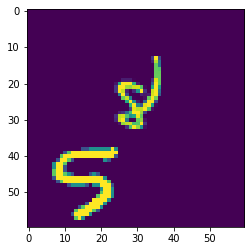

In [6]:
plt.imshow(train_x[1,:,:,0])

Now that the segmentation dataset is loaded, we need to adapt it to reflect the continual setup where classes are seen sequentially. To do so, we will implement a processing function that only keeps the groundtruth masks for the current learning step. For instance, if we divide the 10 classes from MNIST in 5 learning steps of 2 classes, then at step #0 the model is only trained to segment digits 0 and 1, while other digits on the image are labeled as background (i.e. label '0'). Then, at step #1 where the model must learn to segment 2's and 3's, digits 0-1 and 4-9 will be labeled as background, and so on.

This scenario reflects the common experimental setup in which segmentation masks are only available for current classes while objects that belong to past and future classes can still appear in scene images (e.g. from Pascal-VOC) but are labeled as background. This is a challenge specific to Continual Semantic Segmentation known as Background shift, which is addressed in several recent works (MiB, PLOP, SSUL, RECALL, etc). 

In [ ]:
processed_train_y = process_groundtruth(train_y, [0, 1])
processed_test_y = process_groundtruth(test_y, [0, 1])

In [ ]:
train_idx = np.where(np.sum(processed_train_y, axis=(1,2,3))!=0)[0]
processed_train_x = train_x[train_idx]
processed_train_y = processed_train_y[train_idx]
print(processed_train_x.shape, processed_train_y.shape)

test_idx = np.where(np.sum(processed_test_y, axis=(1,2,3))!=0)[0]
processed_test_x = test_x[test_idx]
processed_test_y = processed_test_y[test_idx]
print(processed_test_x.shape, processed_test_y.shape)

(253, 60, 60, 1) (253, 60, 60, 10)
(47, 60, 60, 1) (47, 60, 60, 10)


In [ ]:
processed_train_x = np.transpose(processed_train_x, (0,3,1,2))
processed_train_y = np.transpose(processed_train_y, (0,3,1,2))
processed_test_x = np.transpose(processed_test_x, (0,3,1,2))
processed_test_y  = np.transpose(processed_test_y, (0,3,1,2))

In [ ]:
len(np.where(np.sum(processed_train_y, axis=(1,2,3))!=0)[0])

253

In [ ]:
len(np.where(np.sum(processed_test_y, axis=(1,2,3))!=0)[0])

47

In [ ]:
processed_train_y.shape

(253, 10, 60, 60)

[0.]


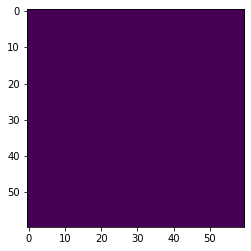

[0.         0.01176471 0.01960784 0.02352941 0.04705882 0.10196078
 0.12941176 0.1372549  0.15294118 0.18823529 0.21960784 0.2627451
 0.2745098  0.4        0.41568627 0.41960784 0.44313725 0.5254902
 0.56862745 0.57254902 0.61568627 0.61960784 0.64313725 0.64705882
 0.65490196 0.65882353 0.6627451  0.6745098  0.67843137 0.74509804
 0.85490196 0.89411765 0.98431373 0.98823529 0.99215686 1.        ]


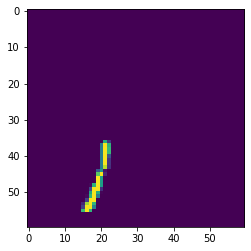

[0.]


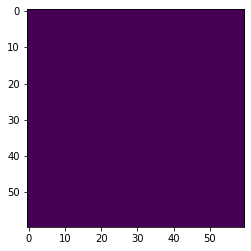

[0.]


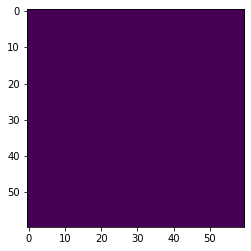

[0.]


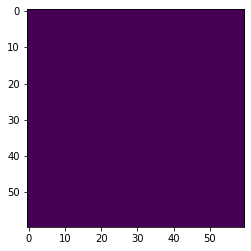

[0.]


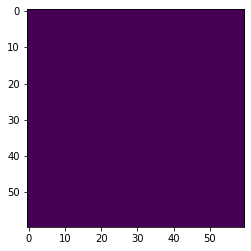

[0.]


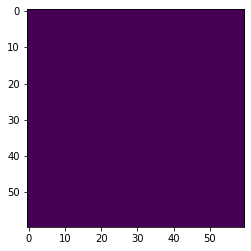

[0.]


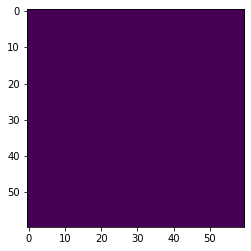

[0.]


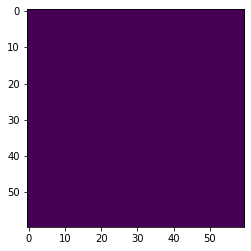

[0.]


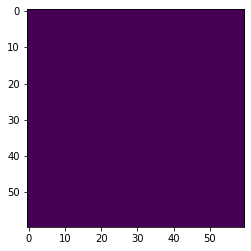

In [ ]:
for i in range(10):
  plt.imshow(processed_train_y[1, :,:,i])
  plt.show()

In [83]:
import torch.utils.data as data
class continual_mnist_extended(data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
    self.classes = np.arange(self.y.shape[-1])
    self.tasks = {0: [0,1], 1: [2,3], 2: [4,5], 3: [6,7], 4: [8,9]}
    self.curr_task_id = 0
    self.curr_classes = self.set_curr_classes()
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def process_groundtruth(self, segmentation_masks):
    processed_masks = []
    num_classes = segmentation_masks.shape[-1]
    for i in range(len(segmentation_masks)):
      mask = np.copy(segmentation_masks[i])
      for j in range(num_classes):
        if j not in self.curr_classes:
          mask[:,:,j] = 0
      processed_masks.append(mask)

    return np.array(processed_masks)

  def set_curr_classes(self):
    curr_classes = self.tasks[self.curr_task_id]
    return curr_classes

  def next_task(self):
    self.curr_task_id += 1
    if self.curr_task_id >= len(self.tasks):
      self.curr_task_id = 0

    self.curr_classes = self.set_curr_classes()
    self.curr_X, self.curr_y = self.get_curr_Xy()

  def get_curr_Xy(self):
    processed_y = self.process_groundtruth(self.y)
    idx = np.where(np.sum(processed_y, axis=(1,2,3))!=0)[0]
    processed_X = self.X[idx]
    processed_y = processed_y[idx]
    processed_X = np.transpose(processed_X, (0,3,1,2))
    processed_y = np.transpose(processed_y, (0,3,1,2))

    return processed_X, processed_y


  def __getitem__(self, index):
    return self.curr_X[index], self.curr_y[index, self.curr_classes]

  def __len__(self):
    return len(self.curr_X)

In [98]:
train_data = continual_mnist_extended(train_x, train_y)
train_loader = data.DataLoader(train_data, batch_size=8)

In [122]:
train_data.curr_classes = [0,1,8,2]
train_data.curr_X, train_data.curr_y = train_data.get_curr_Xy()
train_loader = data.DataLoader(train_data, batch_size=8)

In [123]:
a = next(iter(train_loader))

In [124]:
a[1].shape

torch.Size([8, 4, 60, 60])

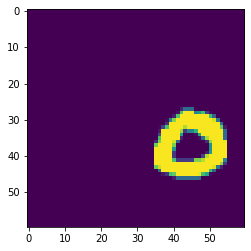

In [139]:
plt.imshow(a[1][4][0])

In [ ]:
test_data = continual_mnist_extended(processed_test_x, processed_test_y, [0,1])
test_loader = data.DataLoader(test_data)

In [ ]:
a = next(iter(train_loader))

In [ ]:
a[0].shape, a[1].shape

(torch.Size([1, 1, 60, 60]), torch.Size([1, 2, 60, 60]))

In [ ]:
class simple_seg_model(torch.nn.Module):
  def __init__(self, conv_filters=32, n_classes=2):
    super(simple_seg_model, self).__init__()
    self.conv_filters = conv_filters
    self.n_classes = n_classes

    self.conv1 = torch.nn.Conv2d(1, self.conv_filters, (3,3), padding=1)
    self.conv2 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv3 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv4 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv5 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv6 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.conv7 = torch.nn.Conv2d(self.conv_filters, self.conv_filters, (3,3), padding=1)
    self.fc = torch.nn.Conv2d(self.conv_filters, self.n_classes, (1,1))

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    x = F.relu(self.conv6(x))
    x = F.relu(self.conv7(x))
    x = torch.sigmoid(self.fc(x))
    return x

s = simple_seg_model()

In [ ]:
s(torch.Tensor(np.zeros((1, 1, 60, 60)))).shape

torch.Size([1, 2, 60, 60])

In [ ]:
class Trainer:
  def __init__(self, model):
    self.model = model
    self.criterion = torch.nn.BCELoss()

  def train(self, cur_epoch, optim, train_loader):

    model = self.model
    model.train()

    for cur_step, (images, labels) in enumerate(train_loader):
      images, labels = images.cuda().float(), labels.cuda().float()
      
      optim.zero_grad()

      outputs = model(images)
      loss = self.criterion(outputs, labels).mean()
      loss.backward()
      optim.step()
      #print(loss)


In [ ]:
s = s.cuda()
trainer = Trainer(s)
optimizer = torch.optim.Adam(lr = 0.01, params=s.parameters())

In [ ]:
for i in range(20):
  trainer.train(0, optimizer, train_loader)

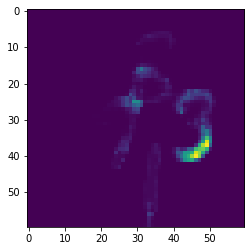

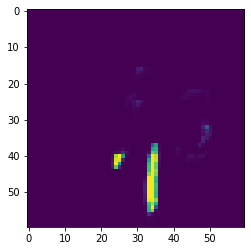

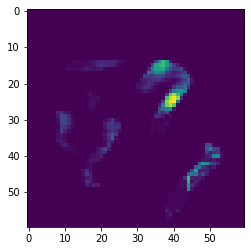

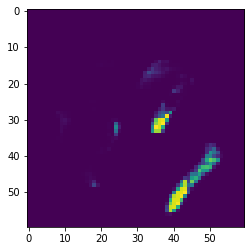

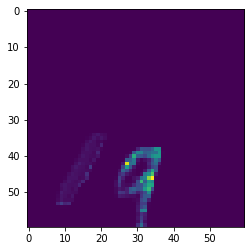

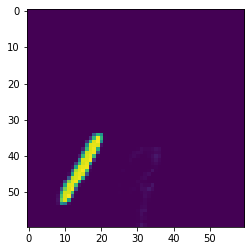

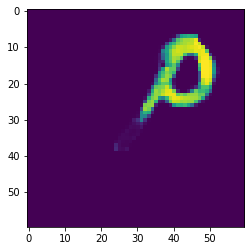

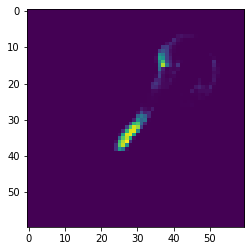

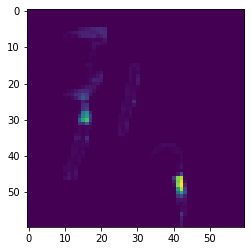

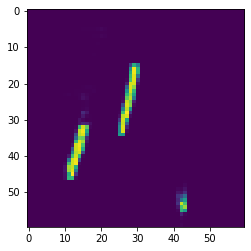

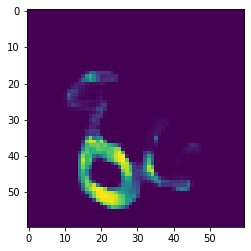

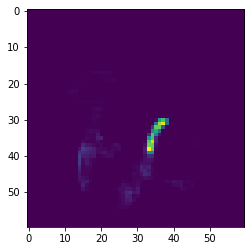

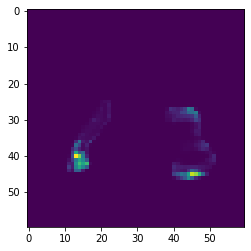

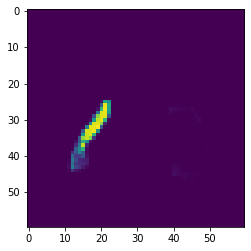

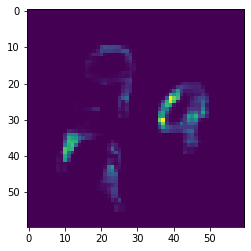

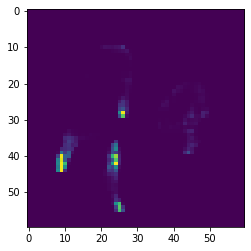

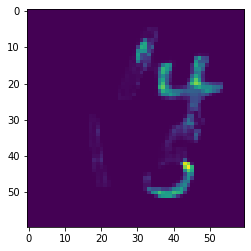

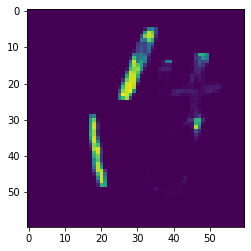

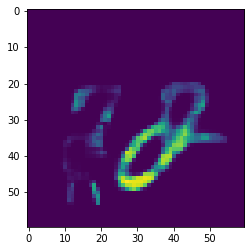

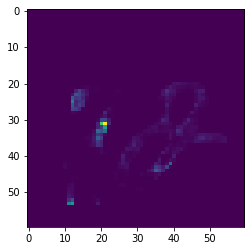

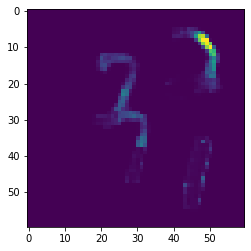

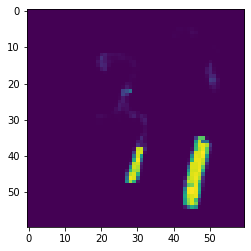

In [ ]:
s.eval()
for j, (images, labels) in enumerate(test_loader):
  x = s(images.cuda().float())
  for i in range(2):
    plt.imshow(x[0,i].detach().cpu())
    plt.show()
  if j == 10:
    break

In [ ]:
# print some MNIST info
x_train, t_train, x_test, t_test = mnist.load()

print(f'Size of training data is: {t_train.shape[0]}, size of test data: {t_test.shape[0]}')

for i in range(10):
  print(f'Size of label {i} in training : {len(t_train[t_train == i])}')

Size of training data is: 60000, size of test data: 10000
Size of label 0 in training : 5923
Size of label 1 in training : 6742
Size of label 2 in training : 5958
Size of label 3 in training : 6131
Size of label 4 in training : 5842
Size of label 5 in training : 5421
Size of label 6 in training : 5918
Size of label 7 in training : 6265
Size of label 8 in training : 5851
Size of label 9 in training : 5949


*We* can start by splitting the data into 5 tasks according to their labels. Since the setting with multiple-head will always classify between two classes, we will modify the labels to be always Class 0 or Class 1. We call this `task_data_with_overlap` since the classes overlap. The single-head naturally supports 10 classes.

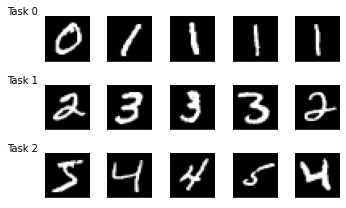

In [ ]:
# tasks to use
task_classes_arr = [(0, 1), (2, 3), (4, 5), (6, 7), (8, 9)]
tasks_num = len(task_classes_arr) # 5

task_data = []
task_data_with_overlap = []
for i, task_classes in enumerate(task_classes_arr):
  train_mask = np.isin(t_train, task_classes)
  test_mask = np.isin(t_test, task_classes)
  x_train_task, t_train_task = x_train[train_mask], t_train[train_mask]
  x_test_task, t_test_task = x_test[test_mask], t_test[test_mask]
  
  task_data.append((x_train_task, t_train_task, x_test_task, t_test_task))
  task_data_with_overlap.append((x_train_task, t_train_task - (i * 2),
                                 x_test_task, t_test_task - (i * 2)))

# Display tasks
def plot_task(axs, data, samples_num):
  for sample in range(samples_num):
    axs[sample].imshow(data[sample][0], cmap="gray")
    # np.vectorize(lambda ax:ax.axis('off'))(axs[sample]);
    axs[sample].xaxis.set_ticks([])
    axs[sample].yaxis.set_ticks([])

n_tasks, samples = 3, 5
_, axs = plt.subplots(n_tasks, samples, figsize=(5, 3))
for task in range(n_tasks):
  axs[task, 0].set_ylabel(f'Task {task}', rotation=0)
  axs[task, 0].yaxis.set_label_coords(-0.5,1)
  plot_task(axs[task], task_data[task][0], samples)
plt.tight_layout()

**Naive strategy with Single Head**

We will first explore continual learning and forgetting by using a single head, 
then by using multiple heads.

The **Naive** strategy simply finetunes the model on the new data, without applying any CL strategies.

In [ ]:
# A basic feedforward net
class FNet(nn.Module):
  def __init__(self, hsize=512):
    super(FNet, self).__init__()

    self.l1 = nn.Linear(784, hsize)
    self.l2 = nn.Linear(hsize, 10)
    
  def forward(self, x):
      x = x.view(x.size(0), -1)
      x = F.relu(self.l1(x))
      x = self.l2(x)
      return x

In [ ]:
def train(model, device, x_train, t_train, optimizer, epochs=10, log_training=False):
    for epoch in range(epochs):
      model.train()
      
      for start in range(0, len(t_train)-1, 256):
        end = start + 256
        x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()

        output = model(x)
        loss = F.cross_entropy(output, y)
        loss.backward()
        optimizer.step()
        if log_training:
          print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max logit
        correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(t_test)
    return test_loss, 100. * correct / len(t_test)

We will train the functions above on task 1 and fine-tune on task 2 to see how additional data affect the performance.

In [ ]:
model = FNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
x_train_1, t_train_1, x_test_1, t_test_1 = task_data[0]
x_train_2, t_train_2, x_test_2, t_test_2 = task_data[1]

print('Training on Task 1')
train(model, device, x_train_1, t_train_1, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')

print('------------')
print('Training on Task 2')
train(model, device, x_train_2, t_train_2, optimizer, epochs=3)

loss, acc = test(model, device, x_test_1, t_test_1)
print(f'Testing on Task 1: loss -> {loss}, acc -> {acc}')
loss, acc = test(model, device, x_test_2, t_test_2)
print(f'Testing on Task 2: loss -> {loss}, acc -> {acc}')

Training on Task 1
Testing on Task 1: loss -> 1.707715103424751e-05, acc -> 99.90543735224587
------------
Training on Task 2
Testing on Task 1: loss -> 0.0674293324175174, acc -> 0.0
Testing on Task 2: loss -> 0.00029021617477571814, acc -> 97.20861900097943


As we can see, the progress we achieved on Task #1 is lost once we fine-tune to Task #2. 

In CL, we talk about **Catastrophic Forgetting**.


**Continual Learning via Rehearsal / Replay:**

One way to mitigate Catastrophic Forgetting is to keep a portion of the old data to be interleaved with the data from the current task, so that the network does not forget. An ideal scenario is to keep all the old data, however, this is not practical in real applications with memory constraints. Therefore, it is preferrable to keep a limited number of old patterns to be replayed.

In the next section we will use the Rehearsal strategy and compare it to the previously seen Naive strategy.

In [ ]:
# We will use this function to shuffle the union of old data with the new task data.
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [ ]:
# we can use this function to train the model on all tasks for a percentage of 
# old data to rehearse. 0% means naive with expected catastrophic forgetting
def train_singlehead(past_examples_percentage=0, epochs=15):
  model = FNet().to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
  accs_fine_grid = []
  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data[i]

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)
    train(model, device, x_train, t_train, optimizer, epochs)

    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data[j]
      _, test_acc = test(model, device, x_test, t_test)
      accs_subset.append(test_acc)
    
    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))

    accs_fine_grid.append(accs_subset)

  return accs_fine_grid



In [ ]:
accs_naive = train_singlehead() # naive: 0%
accs_rehearsal_all = train_singlehead(1) # regural supervised fashion: 100% 
accs_rehearsal_5 = train_singlehead(0.05) # 5%, about 100 example per task

Text(0.5, 24.0, 'Task Number')

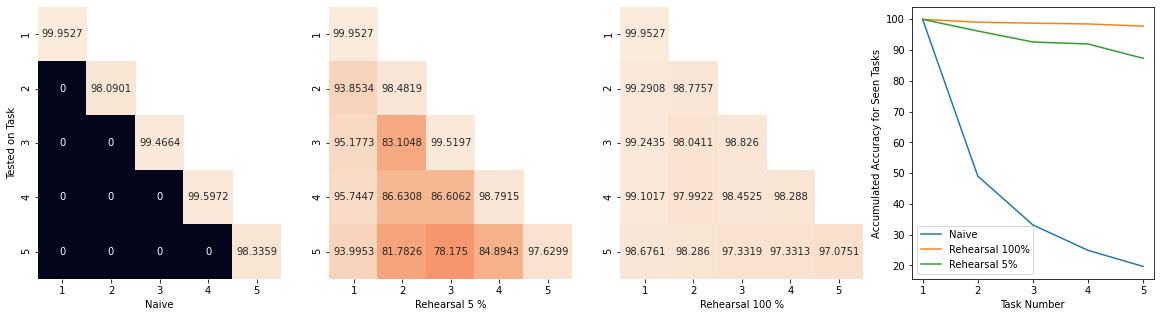

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_naive)
nan_mask = np.isnan(accs_naive)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))
axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')

In the above graph, we saw that accuracy improves by adding 5% of previous data (~50 example per class). Even if forgetting is not completely defeated, it definitely is a step forward from the Naive strategy.

**Multi-Head setting**

In the following section we will move to the multi-head setting and reproduce what we have done with the single-head setting. We will create a `BaseNet` that holds the shared hidden representation to be fine-tuned and a `HeadNet` which holds the separate heads for every task and takes the shared representation as an input. At test time, there will be an oracle that informs us of the task from which each data-point comes from. 



In [ ]:
class FBaseNet(nn.Module):
  def __init__(self, hsize=512):
    super(FBaseNet, self).__init__()
    self.l1 = nn.Linear(784, hsize)

  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = F.relu(self.l1(x))
    return x


class FHeadNet(nn.Module):
  def __init__(self, base_net, input_size=512):
    super(FHeadNet, self).__init__()

    self.base_net = base_net

    self.l1 = nn.Linear(input_size, 2)

  def forward(self, x):
    x = self.base_net.forward(x)
    x = self.l1(x)
    return x

In [ ]:
def train_multihead(past_examples_percentage=0, epochs=15):
  base = FBaseNet().to(device)
  heads = []

  accs_fine_grid = []

  for i in range(tasks_num):
    x_train, t_train, _, _ = task_data_with_overlap[i]
    model = FHeadNet(base).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    heads.append(model)

    # concatenate previous tasks
    for j in range(0, i + 1):
      past_x_train, past_t_train, _, _ = task_data_with_overlap[j]
      example_num = int(past_examples_percentage * len(past_t_train))
      x_train = np.concatenate((x_train, past_x_train[:example_num]))
      t_train = np.concatenate((t_train, past_t_train[:example_num]))

    x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

    train(model, device, x_train, t_train, optimizer, epochs)
    # test on tasks seen so far
    accs_subset = []
    for j in range(0, i + 1):
      _, _, x_test, t_test = task_data_with_overlap[j]
      _, test_acc = test(heads[j], device, x_test, t_test)
      accs_subset.append(test_acc)

    if i < (tasks_num - 1):
      accs_subset.extend([np.nan] * (4 - i))
    
    accs_fine_grid.append(accs_subset)

  return accs_fine_grid


In [ ]:
accs_naive = train_multihead(epochs=15)
accs_rehearsal_all = train_multihead(1, epochs=15)
accs_rehearsal_5 = train_multihead(0.05, epochs=15)

Text(0.5, 24.0, 'Task Number')

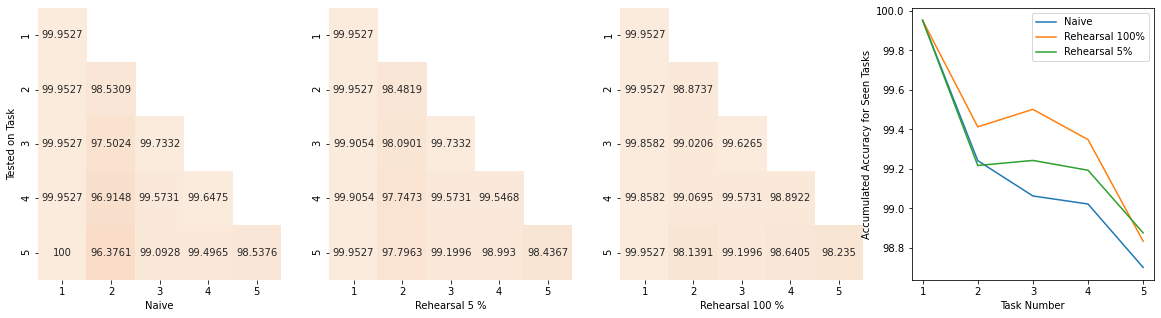

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
accs_fine_grid = np.array(accs_fine_grid)

nan_mask = np.isnan(accs_fine_grid)

sns.heatmap(accs_naive, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[0], cbar=False)
sns.heatmap(accs_rehearsal_5, vmin=0, vmax=100, mask=nan_mask, annot=True,fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[1], cbar=False)
sns.heatmap(accs_rehearsal_all, vmin=0, vmax=100, mask=nan_mask, annot=True,  fmt='g',
            yticklabels=range(1, 6), xticklabels=range(1, 6), ax=axes[2], cbar=False)

axes[0].set_ylabel('Tested on Task')

axes[0].set_xlabel('Naive')
axes[1].set_xlabel('Rehearsal 5 %')
axes[2].set_xlabel('Rehearsal 100 %')


axes[3].plot(range(1, 6), np.nanmean(accs_naive, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_all, axis=1))
axes[3].plot(range(1, 6), np.nanmean(accs_rehearsal_5, axis=1))

axes[3].legend(['Naive', 'Rehearsal 100%', 'Rehearsal 5%'])
axes[3].set_ylabel('Accumulated Accuracy for Seen Tasks')
axes[3].set_xlabel('Task Number')


With the multi-head setting all the strategies maintains a good performance on previous tasks, especially using a simple network. This highlights the unrealistic assumptions behind Multi-Head, which is able to tackle catastrophic forgetting effectively even without any CL strategy. As we already explained, however, multi-head setting is a very unrealistic CL scenario.